<a href="https://www.kaggle.com/code/vedatgul/twitter-nlp-sentiment-analysis-with-modelling?scriptVersionId=144295735" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

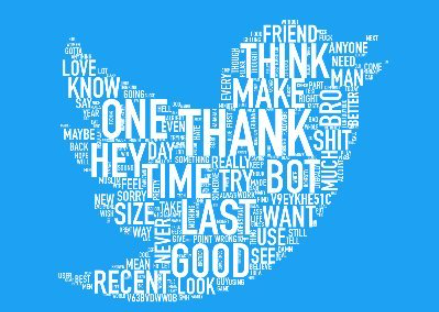

<div style="padding: 40px; background: radial-gradient(circle, #f5f7fa, #e2e9f0); border: 4px double #d1d8e0; border-radius: 30px; box-shadow: 0 10px 20px rgba(0,0,0,0.1); font-size: 120%; line-height: 1.9; color: #333; font-family: 'Georgia', serif; text-align: justify; position: relative;">
    <p style="color: #f39c12; font-size: 135%; border-left: 15px solid #3498db; padding-left: 20px; letter-spacing: 1px;"><strong>Business Problem</strong></p>
    <p>Predicting tweets posted by Twitter users as positive, negative and neutral in terms of the emotion they carry.</p>

<div style="padding: 40px; background: radial-gradient(circle, #f5f7fa, #e2e9f0); border: 4px double #d1d8e0; border-radius: 30px; box-shadow: 0 10px 20px rgba(0,0,0,0.1); font-size: 120%; line-height: 1.9; color: #333; font-family: 'Georgia', serif; text-align: justify; position: relative;">
    <p style="color: #f39c12; font-size: 135%; border-left: 15px solid #3498db; padding-left: 20px; letter-spacing: 1px;"><strong>Dataset Story</strong></p>
    <p>'tweet_labeled.csv' contains the tweets made in Twitter 2022, the dates of the tweets, and the labels as -1, 0 and 1 within the scope of the emotion contained in the tweets. 'tweets_21.csv' contains tweets from 2021. 

 <p style="color: #3498db; font-size: 110%; border-left: 15px solid #f39c12; padding-left: 20px; letter-spacing: 1px;"><strong>tweets_labeled.csv</strong></p>
        
 **tweet_id:** id information of tweet
        
 **tweet:** tweet content
        
 **date:** date and time of tweet
        
 **label:** Tag information based on the sentiment of the tweet (-1:negative, 0:neutral, 1:positive )
        
        
    
 <p style="color: #3498db; font-size: 110%; border-left: 15px solid #f39c12; padding-left: 20px; letter-spacing: 1px;"><strong>tweets_21.csv</strong></p>
    
 **tweet_id:** id information of tweet
        
 **tweet:** tweet content
        
 **date:** date and time of tweet
    

In [ ]:
# Download the libraries if you don't have
!pip install nltk
!pip install twython
!pip install textblob
!pip install wordcloud
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import  LabelEncoder
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings
from PIL import Image

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 400)

In [ ]:
df=pd.read_csv("/kaggle/input/nlp-tweets/tweets_labeled.csv")
df

In [ ]:
df.columns

In [ ]:
df.shape

In [ ]:
df.info()

# <div style="padding: 30px; color:white; margin:10; font-size:150%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'> 1 |</span></b> <b>Date Preprocessing</b></div>

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df["date"] = df["date"].dt.tz_convert("Europe/Istanbul")
df['date'] = df['date'].dt.tz_localize(None)

In [ ]:
df['month'] = df['date'].dt.month_name()
df['tweet'] = df['tweet'].str.lower()
df

In [ ]:
# Creating the variable "seasons"
seasons = {'January': 'Winter',
           'February': 'Winter',
           'March': 'Spring',
           'April': 'Spring',
           'May': 'Spring',
           'June': 'Summer',
           'July': 'Summer',
           'August': 'Summer',
           'September': 'Autumn',
           'October': 'Autumn',
           'November': 'Autumn',
           'December': 'Winter'}

In [ ]:
df['seasons'] = df['month'].map(seasons)
df

In [ ]:
# Creation of the day variable
df["days"] = [date.strftime('%A') for date in df["date"]]
df

In [ ]:
df["hour"] = df["date"].dt.hour
df

In [ ]:
df['4hour_interval'] = (df['hour'] // 2) * 2
df

In [ ]:
interval = {0: '0-2',
            2: '2-4',
            4: '4-6',
            6: '6-8',
            8: '8-10',
            10: '10-12',
            12: '12-14',
            14: '14-16',
            16: '16-18',
            18: '18-20',
            20: '20-22',
            22: '22-24'
            }

In [ ]:
df['4hour_interval'] = df['4hour_interval'].map(interval)
df

In [ ]:
df["time_interval"] = df["4hour_interval"].replace({"0-2": "22-02",
                                                   "22-24": "22-02",
                                                   "2-4": "02-06",
                                                   "4-6": "02-06",
                                                   "6-8": "06-10",
                                                   "8-10": "06-10",
                                                   "10-12": "10-14",
                                                   "12-14": "10-14",
                                                   "14-16": "14-18",
                                                   "16-18": "14-18",
                                                   "18-20": "18-22",
                                                   "20-22": "18-22"})

In [ ]:
df.drop(["4hour_interval", "hour"], axis=1, inplace=True)

In [ ]:
label = {1: 'positive',
        -1: 'negative',
        0: 'neutral'
         }
df['label'] = df['label'].map(label)
df

In [ ]:
def summary(dataframe, col_name, plot=False):
    # negatif tweetler için hedef değişken analizi
    dataframe = dataframe.loc[df["label"] == 'negative']
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("---------------------------------------------")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

In [ ]:
cols = ["time_interval", "days", "seasons"]
for col in cols:
    summary(df, col, plot=True)

# <div style="padding: 30px; color:white; margin:10; font-size:150%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'> 2 |</span></b> <b>Text Preprocessing</b></div>

<div style="padding: 40px; background: radial-gradient(circle, #f5f7fa, #e2e9f0); border: 4px double #d1d8e0; border-radius: 30px; box-shadow: 0 10px 20px rgba(0,0,0,0.1); font-size: 120%; line-height: 1.9; color: #333; font-family: 'Georgia', serif; text-align: justify; position: relative;">
    <p style="color: #f39c12; font-size: 135%; border-left: 15px solid #3498db; padding-left: 20px; letter-spacing: 1px;"><strong></strong></p>
   
**Convert Text to Lowercase:** Writing text entirely in lower case helps to avoid the difference between upper and lower case.

**Removing Punctuation:** Punctuation marks (periods, commas, exclamation marks, question marks, etc.) often add unnecessary noise to text.

**Replace Numbers with a Space:** You can replace numbers with a space character or other non-deterministic character.

**Removing stopwords:** Stop words, (e.g., "and", "or", "but", "that") are usually unimportant for text analysis and can therefore be removed.

**Lemmatisation:** These operations, called stemming operations, help to find the root of the word or convert the word to its dictionary meaning. For example, you can translate the word "running" into "run". to the word "word".</p>

In [ ]:
def clean_text(text):
    # Normalizing Case Folding
    text = text.str.lower()
    # Punctuations
    text = text.str.replace(r"[^\w\s]", "",regex=True)
    text = text.str.replace("\n" , "")
    # Numbers
    text = text.str.replace("\d", "",regex=True)
    # Stopwords
    sw = stopwords.words("turkish")
    text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
    # Lemmatization
    text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    return text

df["tweet"] = clean_text(df["tweet"])

df.head()

# <div style="padding: 30px; color:white; margin:10; font-size:150%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>3 |</span></b> <b>Data Visualisation</b></div>

<div style="padding: 40px; background: radial-gradient(circle, #f5f7fa, #e2e9f0); border: 4px double #d1d8e0; border-radius: 30px; box-shadow: 0 10px 20px rgba(0,0,0,0.1); font-size: 120%; line-height: 1.9; color: #333; font-family: 'Georgia', serif; text-align: justify; position: relative;">
    <p style="color: #f39c12; font-size: 135%; border-left: 15px solid #3498db; padding-left: 20px; letter-spacing: 1px;"><strong></strong></p>
   
**Barplot:** Barplot is a type of graph used to visualise categorical data. It is often used to show frequencies or relationships of frequently occurring categorical values.

**Word Cloud:** Word Cloud is a type of chart used to visualise text data and highlight the importance of certain words. They are visually represented in different sizes and colours according to the frequency of the words in the text.</p>

In [ ]:
# Barplot
tf = df["tweet"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

In [ ]:
# Wordcloud
text = " ".join(i for i in df.tweet)
tr_mask = np.array(Image.open("/kaggle/input/ccccccdef/ccc.png"))

wc = WordCloud(background_color="black",
               max_words=1000,
               mask=tr_mask,
               contour_width=3,
               contour_color="firebrick")

wc.generate(text)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# <div style="padding: 30px; color:white; margin:10; font-size:150%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>4 |</span></b> <b>Sentiment Analysis</b></div>

In [ ]:
df["label"] = LabelEncoder().fit_transform(df["label"])
df

In [ ]:
 df.dropna(axis=0, inplace=True)

<div style="padding: 40px; background: radial-gradient(circle, #f5f7fa, #e2e9f0); border: 4px double #d1d8e0; border-radius: 30px; box-shadow: 0 10px 20px rgba(0,0,0,0.1); font-size: 120%; line-height: 1.9; color: #333; font-family: 'Georgia', serif; text-align: justify; position: relative;">
    <p style="color: #f39c12; font-size: 135%; border-left: 15px solid #3498db; padding-left: 20px; letter-spacing: 1px;"><strong></strong></p>
   
**TF-IDF Word Level** is a measure used to determine the importance of a term within a document, and this measure is based on the frequency of the term within the document and its prevalence across all documents.</p>

In [ ]:
# TF-IDF Word Level
tf_idfVectorizer = TfidfVectorizer()
X = tf_idfVectorizer.fit_transform(df["tweet"])
y = df["label"]

In [ ]:
# Modelling(Logistic Regression)
log_model = LogisticRegression(max_iter=10000).fit(X, y)

In [ ]:
# Cross Validation
cross_val_score(log_model,
                X,
                y,
                scoring="accuracy",
                cv=10).mean()

In [ ]:
# Twitter 2021 data
df_tweet_21=pd.read_csv("/kaggle/input/nlp-tweets/tweets_21.csv")
df_tweet_21

In [ ]:
# Feature Engineering
df_tweet_21["tweet"] = clean_text(df_tweet_21["tweet"])
df_tweet_21

In [ ]:
# Prediction
tweet_tfidf = tf_idfVectorizer.transform(df_tweet_21["tweet"])
predictions = log_model.predict(tweet_tfidf)
df_tweet_21["label"] = predictions
df_tweet_21